# Population-based Optimization Methods  
## Example Project: Deceptive Trap Function Optimization

This notebook presents a complete example of a project for the course
**Population-based Optimization Methods**, focusing on a deceptive problem.

We consider a **deceptive Trap function**, which is designed to:
- mislead greedy and local search methods,
- reward short-term improvements that lead away from the global optimum.

We compare:
- a **Genetic Algorithm (GA)**,
- **Random Search (RS)**,
- **Simulated Annealing (SA)**.



## The Deceptive Trap Function

The Trap function divides a binary genome into disjoint blocks of size `k`.

For each block:
- if all bits are `1`, the block contributes a high reward,
- otherwise, the block gives a misleading reward that increases as the number
  of zeros increases (meaning that the reward is higher if the solution is further away from the global optimum).

This creates **deception**:
- local optima exist at blocks of all zeros,
- the global optimum is the all-ones string,
- greedy, local-search strategies could be misled.


In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.multitest import multipletests


## Reproducibility

We generate 30 fixed random seeds using a master generator seeded with 42.
Each repetition uses the same seed across all methods.


In [2]:
MASTER_SEED = 42
REPETITIONS = 30

master_rng = np.random.default_rng(MASTER_SEED)
SEEDS = master_rng.integers(0, 1_000_000, size=REPETITIONS)


## Trap Function Definition


In [3]:
GENOME_LENGTH = 100
TRAP_SIZE = 5
NUM_BLOCKS = GENOME_LENGTH // TRAP_SIZE

if GENOME_LENGTH % TRAP_SIZE != 0:
    raise ValueError(f"GENOME LENGTH {GENOME_LENGTH} CANNOT BE DIVIDED BY TRAP_SIZE {TRAP_SIZE}!")

def trap_block(block: np.ndarray) -> int:
    ones = np.sum(block)
    if ones == TRAP_SIZE:
        return TRAP_SIZE
    else:
        return TRAP_SIZE - 1 - ones

def fitness(individual: np.ndarray) -> int:
    total = 0
    for i in range(NUM_BLOCKS):
        block = individual[i * TRAP_SIZE:(i + 1) * TRAP_SIZE]
        total += trap_block(block)
    return total

def actual_quality(individual: np.ndarray) -> int:
    return int(np.sum(individual))

### Why this Function is Hard

For each block:
- the configuration `00000` is a **local optimum**,
- any single-bit flip from `00000` reduces fitness instead of improving it!


### A Note on Evaluation Metrics

In the Trap function, fitness is intentionally deceptive.
High fitness does not necessarily correspond to a high number of ones in the genome.

For this reason, we distinguish between:
- **Trap fitness** (the objective optimized by the algorithms), and
- **Quality: number of ones**, which measures similarity to the global optimum (all-ones string).


In [4]:
def tournament_selection(population, fitnesses, tournament_size, rng):
    indices = rng.choice(len(population), size=tournament_size, replace=False)
    best_idx = indices[np.argmax(fitnesses[indices])]
    return population[best_idx].copy()

def crossover(p1, p2, crossover_rate, rng):
    if rng.random() < crossover_rate:
        point = rng.integers(1, len(p1))
        return np.concatenate([p1[:point], p2[point:]])
    return p1.copy()

def mutate(individual, mutation_rate, rng):
    for i in range(len(individual)):
        if rng.random() < mutation_rate:
            individual[i] = 1 - individual[i]


In [5]:
def genetic_algorithm(
    pop_size,
    generations,
    mutation_rate,
    tournament_size,
    seed
):
    rng = np.random.default_rng(seed)

    population = rng.integers(0, 2, size=(pop_size, GENOME_LENGTH))

    best_fitness_over_time = []

    # Track best-so-far solution (elitist individual)
    best_individual = None
    best_fitness = -np.inf

    for _ in range(generations):
        fitnesses = np.array([fitness(ind) for ind in population])

        # Update best-so-far
        gen_best_idx = np.argmax(fitnesses)
        gen_best_fitness = fitnesses[gen_best_idx]

        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = population[gen_best_idx].copy()

        best_fitness_over_time.append(best_fitness)

        # Elitism: keep the best individual
        new_population = [best_individual.copy()]

        # Fill the rest of the population
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses, tournament_size, rng)
            p2 = tournament_selection(population, fitnesses, tournament_size, rng)
            child = crossover(p1, p2, crossover_rate=0.9, rng=rng)
            mutate(child, mutation_rate, rng)
            new_population.append(child)

        population = np.array(new_population)

    return best_fitness, best_fitness_over_time, best_individual


In [6]:
def random_search(evaluations, seed):
    rng = np.random.default_rng(seed)

    best_fitness = -np.inf
    best_individual = None

    for _ in range(evaluations):
        individual = rng.integers(0, 2, size=GENOME_LENGTH)
        fit = fitness(individual)

        if fit > best_fitness:
            best_fitness = fit
            best_individual = individual.copy()

    return best_fitness, best_individual


In [7]:
def simulated_annealing(evaluations, seed, initial_temp=1.0, cooling_rate=0.99):
    rng = np.random.default_rng(seed)

    current = rng.integers(0, 2, size=GENOME_LENGTH)
    current_fit = fitness(current)

    best_fitness = current_fit
    best_individual = current.copy()

    temp = initial_temp

    for _ in range(evaluations):
        neighbor = current.copy()
        idx = rng.integers(0, GENOME_LENGTH)
        neighbor[idx] = 1 - neighbor[idx]

        neighbor_fit = fitness(neighbor)
        delta = neighbor_fit - current_fit

        if delta > 0 or rng.random() < np.exp(delta / temp):
            current = neighbor
            current_fit = neighbor_fit

        if current_fit > best_fitness:
            best_fitness = current_fit
            best_individual = current.copy()

        temp *= cooling_rate

    return best_fitness, best_individual


In [8]:
POP_SIZE = 50
GENERATIONS = 100
EVALUATIONS = POP_SIZE * GENERATIONS


In [9]:
ga_results, ga_trends, ga_quality = [], [], []
rs_results, sa_results, rs_quality, sa_quality = [], [], [], []

for seed in SEEDS:
    best, trend, best_ind = genetic_algorithm(POP_SIZE, GENERATIONS, 0.01, 3, seed)
    ga_results.append(best)
    ga_trends.append(trend)
    ga_quality.append(actual_quality(best_ind))

    rs_best, rs_best_ind = random_search(EVALUATIONS, seed)
    sa_best, sa_best_ind = simulated_annealing(EVALUATIONS, seed)
    
    rs_results.append(rs_best)
    sa_results.append(sa_best)
    rs_quality.append(actual_quality(rs_best_ind))
    sa_quality.append(actual_quality(sa_best_ind))


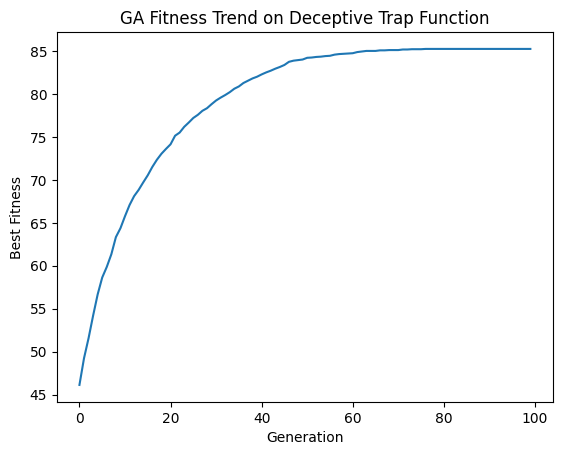

In [10]:
avg_trend = np.mean(ga_trends, axis=0)

plt.plot(avg_trend)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Fitness Trend on Deceptive Trap Function")
plt.show()


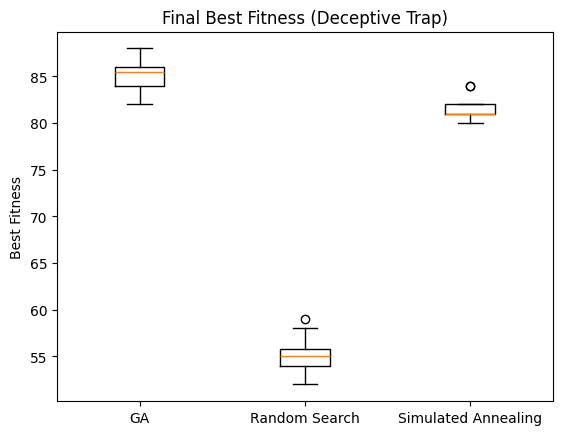

In [11]:
plt.boxplot(
    [ga_results, rs_results, sa_results],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Fitness")
plt.title("Final Best Fitness (Deceptive Trap)")
plt.show()


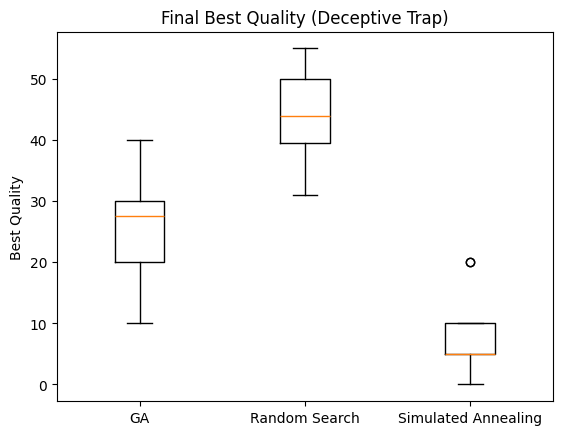

In [12]:
plt.boxplot(
    [ga_quality, rs_quality, sa_quality],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Quality")
plt.title("Final Best Quality (Deceptive Trap)")
plt.show()


**“Which algorithm optimizes the Trap function best?”** -> In this specific context, GA is able to reach higher fitness values compared to RS and SA. 

**“Which algorithm gets closer to the all-ones string?”** -> However, if we consider that the quality of a solution is its similarity to the all-ones string (global optimum), then we discover that RS is actually the approach that leads to higher quality solutions, considering the rugged landscape we have!

In [13]:
def create_results_dict(scores: list[float]) -> dict[str, float]:
    res = {
        "scores": scores,
        "min": min(scores),
        "q1": float(np.percentile(scores, 25)),
        "median": statistics.median(scores),
        "q3": float(np.percentile(scores, 75)),
        "max": max(scores),
        "mean": statistics.mean(scores),
        "std": statistics.pstdev(scores)
    }
    return res


def is_kruskalwallis_passed(data: dict[str, list[float]], alpha: float = 0.05) -> bool:
    l = [data[key] for key in data]
    _, kruskal_pvalue = stats.kruskal(*l)
    return bool(kruskal_pvalue < alpha)


def is_mannwhitneyu_passed(data1: list[float], data2: list[float], alternative: str, alpha: float = 0.05) -> tuple[bool, float]:
    if data1 != data2:
        _, w_pval = stats.mannwhitneyu(data1, data2, alternative=alternative, method="auto")
        is_the_mannwhitney_test_meaningful: bool = bool(w_pval < alpha)
        return is_the_mannwhitney_test_meaningful, w_pval
    else:
        return False, 1.0


def perform_mannwhitneyu_holm_bonferroni(data: dict[str, list[float]], alternative: str, alpha: float = 0.05, method: str = 'holm') -> tuple[dict[str, bool], dict[str, dict[str, bool]]]:
    if len(data) <= 1:
        raise AttributeError(f'data must have at least two entries, found {len(data)} instead.')
    
    hb_res = {k1: False for k1 in data}
    mwu_res = {k1: {k2: False for k2 in data} for k1 in data}

    for method1 in data:
        a = data[method1]
        all_p_vals = []
        for method2 in data:
            if method2 != method1:
                b = data[method2]
                is_the_mannwhitney_test_meaningful, w_pval = is_mannwhitneyu_passed(a, b, alternative=alternative, alpha=alpha)
                all_p_vals.append(w_pval)
                mwu_res[method1][method2] = is_the_mannwhitney_test_meaningful
        all_p_vals.sort()
        reject_bonferroni, _, _, _ = multipletests(all_p_vals, alpha=alpha, method=method)
        is_the_bonferroni_test_meaningful: bool = bool(np.sum(reject_bonferroni) == len(all_p_vals))
        hb_res[method1] = is_the_bonferroni_test_meaningful
    
    if len(data) == 2:
        keys = sorted(list(data.keys()))
        first_method, second_method = keys[0], keys[1]
        hb_res[first_method] = mwu_res[first_method][second_method]
        hb_res[second_method] = mwu_res[second_method][first_method]

    return hb_res, mwu_res

In [14]:
ALPHA = 0.05

results = {
    "GA": ga_results,
    "RS": rs_results,
    "SA": sa_results
}

print("Kruskal-Wallis passed:", is_kruskalwallis_passed(results, alpha=ALPHA))

hb, pairwise = perform_mannwhitneyu_holm_bonferroni(
    results,
    alternative="greater",
    alpha=ALPHA
)

for method1 in pairwise:
    for method2 in pairwise:
        if method1 != method2:
            if pairwise[method1][method2]:
                print(f"{method1} leads to a fitness that is higher than the fitness of {method2} in a statistically significant way according to a Mann-Whitney U test.")

for method in hb:
    if hb[method]:
        print(f"{method} leads to the best fitness according to a Holm-Bonferroni correction!")


Kruskal-Wallis passed: True
GA leads to a fitness that is higher than the fitness of RS in a statistically significant way according to a Mann-Whitney U test.
GA leads to a fitness that is higher than the fitness of SA in a statistically significant way according to a Mann-Whitney U test.
SA leads to a fitness that is higher than the fitness of RS in a statistically significant way according to a Mann-Whitney U test.
GA leads to the best fitness according to a Holm-Bonferroni correction!


## Interpretation of the Results

On the deceptive Trap function, GA clearly outperforms both RS and SA regarding the fitness function.

Possible justifications:
- SA behaves like a local search method,
- it is attracted to deceptive local optima (all-zero blocks),
- escaping these basins requires coordinated bit flips, which are unlikely.

GA, instead:
- maintains a population of solutions,
- recombines building blocks via crossover,
- since more solutions at a time are analyzed, it should be easier to escape traps.

This landscape is indeed very rugged. As a result, when analyzing the **actual quality** of the solutions, RS performs the best.


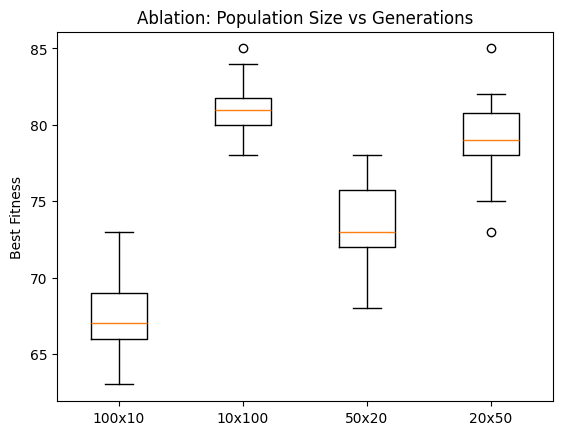

In [15]:
configs = [(100, 10), (10, 100), (50, 20), (20, 50)]
ablation_pg = {}

for pop, gen in configs:
    scores = []
    for seed in SEEDS:
        best, _, _ = genetic_algorithm(
            pop_size=pop,
            generations=gen,
            mutation_rate=0.01,
            tournament_size=3,
            seed=seed
        )
        scores.append(best)
    ablation_pg[f"{pop}x{gen}"] = scores

plt.boxplot(ablation_pg.values(), labels=ablation_pg.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Population Size vs Generations")
plt.show()


From this ablation, we see that smaller population size and higher number of generations behave better than the opposite.

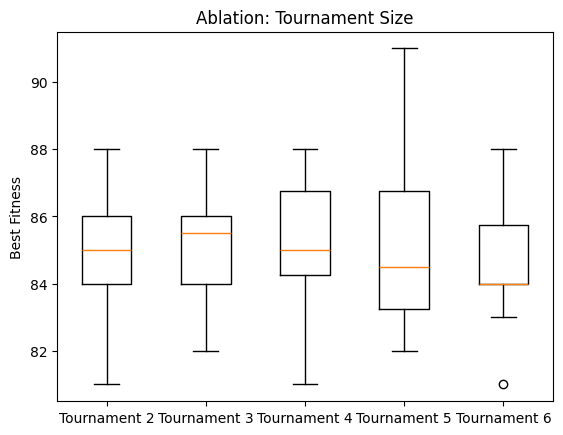

In [16]:
tournament_sizes = [2, 3, 4, 5, 6]
ablation_ts = {}

for ts in tournament_sizes:
    scores = []
    for seed in SEEDS:
        best, _, _ = genetic_algorithm(
            pop_size=POP_SIZE,
            generations=GENERATIONS,
            mutation_rate=0.01,
            tournament_size=ts,
            seed=seed
        )
        scores.append(best)
    ablation_ts[f"Tournament {ts}"] = scores

plt.boxplot(ablation_ts.values(), labels=ablation_ts.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Tournament Size")
plt.show()


Here, we see that the impact of tournament size is not meaningful. Probably, a small tournament size (3 or 4) represents the ideal choice.

### What happens if we decrease population size?

In [17]:
POP_SIZE = 10
GENERATIONS = 100
EVALUATIONS = POP_SIZE * GENERATIONS


In [18]:
ga_results, ga_trends, ga_quality = [], [], []
rs_results, sa_results, rs_quality, sa_quality = [], [], [], []

for seed in SEEDS:
    best, trend, best_ind = genetic_algorithm(POP_SIZE, GENERATIONS, 0.01, 3, seed)
    ga_results.append(best)
    ga_trends.append(trend)
    ga_quality.append(actual_quality(best_ind))

    rs_best, rs_best_ind = random_search(EVALUATIONS, seed)
    sa_best, sa_best_ind = simulated_annealing(EVALUATIONS, seed)
    
    rs_results.append(rs_best)
    sa_results.append(sa_best)
    rs_quality.append(actual_quality(rs_best_ind))
    sa_quality.append(actual_quality(sa_best_ind))


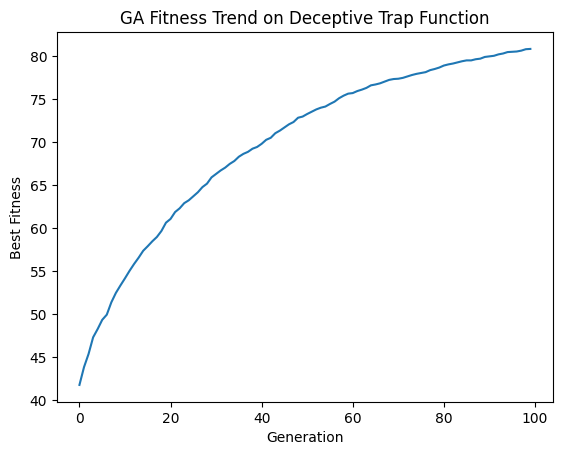

In [19]:
avg_trend = np.mean(ga_trends, axis=0)

plt.plot(avg_trend)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Fitness Trend on Deceptive Trap Function")
plt.show()


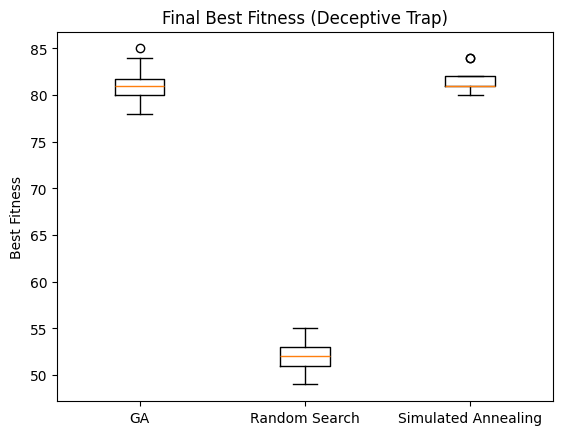

In [20]:
plt.boxplot(
    [ga_results, rs_results, sa_results],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Fitness")
plt.title("Final Best Fitness (Deceptive Trap)")
plt.show()


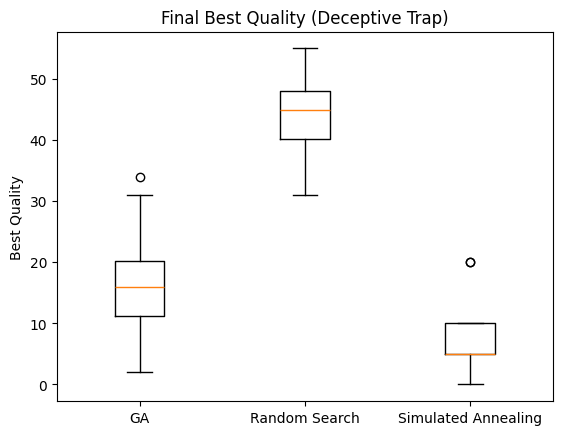

In [21]:
plt.boxplot(
    [ga_quality, rs_quality, sa_quality],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Quality")
plt.title("Final Best Quality (Deceptive Trap)")
plt.show()


If population size is smaller, without changing the number of generations, SA improves and matches the performance of GA in case of the trap fitness function. Basically, in the short run, SA seems as good as GA. As regards the quality itself, RS is still the algorithm leading to higher quality solutions.